In [1]:
import numpy as np
import pandas as pd
from joblib import delayed, Parallel

In [2]:
class paths:
    TRAIN = './data/train.csv'
    TEST = './data/test.csv'

In [3]:
df = pd.read_csv(paths.TRAIN)

In [4]:
from sklearn.decomposition import PCA

def full_feature_engineering(df):
    new_df = df.copy()
    new_df['Height'] = np.abs(new_df['Y_Maximum'] - new_df['Y_Minimum'])
    new_df['Width'] = np.abs(new_df['X_Maximum'] - new_df['X_Minimum'])
    new_df[['Log_Outside_X_Index', 
            'Log_X_Perimeter', 'Log_Y_Perimeter']] = np.log(new_df[['Outside_X_Index', 
                                                                    'X_Perimeter', 'Y_Perimeter']] + 1e-6)
    new_df[['Log_Width', 'Log_Height']] = np.log(new_df[['Width', 'Height']] + 1)
    new_df['Abs_Orientation'] = np.abs(new_df['Orientation_Index'])
    new_df['Log_Range'] = np.log(1 + new_df['Maximum_of_Luminosity']) - np.log(1 + new_df['Minimum_of_Luminosity'])
    new_df['Log_Lum'] = np.log(new_df['Sum_of_Luminosity'])
    new_df['Log_Avg_Lum'] = new_df['Log_Lum'] - 2 * new_df['LogOfAreas']

    y_cols = ['Pastry', 'Z_Scratch', 'K_Scatch',
              'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
    non_cols = ['id'] + y_cols
    
    X = new_df.drop(columns=non_cols)
    X_stats = X.describe().T
    X = (X - X_stats['mean']) / X_stats['std']
    n_components = 15
    pca = PCA(n_components=n_components).fit(X)
    new_df[[f'pca_{i}' for i in range(n_components)]] = pca.transform(X)

    new_df['No Defect'] = (new_df[y_cols].sum(axis=1) == 0).astype('int')

    drop_cols = ['Y_Maximum', 'Y_Minimum', 'X_Maximum', 'X_Minimum']
    return new_df.drop(columns=drop_cols)

In [5]:
train_df = full_feature_engineering(df)
y_cols = ['No Defect', 'Pastry', 'Z_Scratch', 'K_Scatch',
          'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
y = train_df[y_cols]
X = train_df.drop(y, axis=1)
ids = X['id']
X = X.drop(['id'], axis=1)

In [6]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

trains = []
valids = []
for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, ids)):
    print(f'Fold: {fold}')
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    valid_X = X.loc[valid_index]
    valid_y = y.loc[valid_index]
    trains.append((train_X, train_y))
    valids.append((valid_X, valid_y))

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 5
lr = 0.05

xgboosts = []
aucs = np.zeros(8)

X_drop_cols = ['Log_Outside_X_Index','Log_X_Perimeter',
               'Log_Y_Perimeter','Log_Width','Log_Height',
               'Log_Lum']

X_use_cols = ['pca_0',
'TypeOfSteel_A300',
'LogOfAreas',
'Pixels_Areas',
'Steel_Plate_Thickness',
'Orientation_Index',
'Length_of_Conveyer',
'Outside_X_Index',
'Width',
'Edges_Y_Index',
'pca_2',
'pca_1',
'Y_Perimeter']

for fold in range(5):
    print(f'Fold: {fold}')

    X, y = trains[fold]
    Xv, yv = valids[fold]
    #X = X[X_use_cols]
    #Xv = Xv[X_use_cols]

    # Fit Model
    model = XGBClassifier(n_estimators=estimators,
                          early_stopping_rounds=stopping,
                          learning_rate=lr,
                          n_jobs=-1,
                          subsample=0.8
                          )
    model.fit(X, y, eval_set=[(Xv, yv)], verbose=0)
    xgboosts.append(model)

    # Calculate ROCS
    preds = model.predict_proba(Xv)
    aucs += np.array(roc_auc_score(yv, preds, multi_class='ovr', average=None))
    
val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
essential_aucs = val_aucs.drop(index='No Defect')
print(f'Mean AUC of 7: {essential_aucs.mean():.4f}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


No Defect       0.638839
Pastry          0.869779
Z_Scratch       0.957004
K_Scatch        0.984856
Stains          0.991541
Dirtiness       0.879103
Bumps           0.804888
Other_Faults    0.702790
dtype: float64

Mean AUC of 7: 0.8843


In [36]:
importances = xgboosts[0].feature_importances_
for xgboost in xgboosts[1:]:
    importances += xgboost.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {sortd[i]:.2f}')

pca_0: 0.24
TypeOfSteel_A300: 0.15
Pixels_Areas: 0.10
Steel_Plate_Thickness: 0.09
LogOfAreas: 0.07
Length_of_Conveyer: 0.06
Outside_X_Index: 0.05
Orientation_Index: 0.04
Edges_Y_Index: 0.04
Y_Perimeter: 0.04
pca_1: 0.04
pca_2: 0.04
Width: 0.03


## RF

In [8]:
from sklearn.ensemble import RandomForestClassifier

estimators = 500

rfs = []
aucs = np.zeros(8)

for fold in range(5):
    print(f'Fold: {fold}')

    # Fit Model
    model = RandomForestClassifier(n_estimators=estimators,
                                   n_jobs=-1,
                                   max_features=0.5)
    model.fit(*trains[fold])
    rfs.append(model)

    # Calculate ROCS
    X_val, y_val = valids[fold]
    preds = np.array(model.predict_proba(X_val))[:,:,1].T
    aucs += np.array(roc_auc_score(y_val, preds,
                     multi_class='ovr', average=None))

val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
essential_aucs = val_aucs.drop(index='No Defect')
print(f'Mean AUC of 7: {essential_aucs.mean():.4f}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


No Defect       0.650295
Pastry          0.863441
Z_Scratch       0.945279
K_Scatch        0.983539
Stains          0.991400
Dirtiness       0.881969
Bumps           0.796064
Other_Faults    0.685182
dtype: float64

Mean AUC of 7: 0.8781


In [9]:
importances = np.array(rfs[0].feature_importances_)
for rf in rfs[1:]:
    importances += rf.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(trains[0][0].columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {sortd[i]:.2f}')

pca_0: 0.10
Outside_X_Index: 0.03
Log_Width: 0.03
Width: 0.03
Log_Outside_X_Index: 0.03
pca_9: 0.03
Length_of_Conveyer: 0.03
pca_7: 0.03
Steel_Plate_Thickness: 0.03
pca_2: 0.03
pca_1: 0.02
Log_Range: 0.02
pca_8: 0.02
Edges_Index: 0.02
pca_14: 0.02
LogOfAreas: 0.02
pca_13: 0.02
pca_11: 0.02
pca_6: 0.02
pca_4: 0.02
pca_12: 0.02
Pixels_Areas: 0.02
Empty_Index: 0.02
pca_10: 0.02
pca_3: 0.02
pca_5: 0.02
Luminosity_Index: 0.02
Orientation_Index: 0.02
Log_Avg_Lum: 0.02
Edges_X_Index: 0.02
Log_X_Index: 0.02
Minimum_of_Luminosity: 0.02
Edges_Y_Index: 0.01
Log_Height: 0.01
Height: 0.01
SigmoidOfAreas: 0.01
Sum_of_Luminosity: 0.01
Maximum_of_Luminosity: 0.01
Square_Index: 0.01
Abs_Orientation: 0.01
Log_Lum: 0.01
Log_Y_Index: 0.01
Log_X_Perimeter: 0.01
X_Perimeter: 0.01
Y_Perimeter: 0.01
Log_Y_Perimeter: 0.01
TypeOfSteel_A300: 0.01
TypeOfSteel_A400: 0.00
Outside_Global_Index: 0.00


# Class-Based Importances

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 20
lr = 0.05

aucs = pd.Series()

for i, col in enumerate(y_cols):
    print('='*30)
    print(col)
    print('='*30)
    xgboosts=[]
    aucs_sum = 0
    for fold in range(5):
        
        X, y = trains[fold]
        y_col = np.array(y[col])
        X_val, y_val = valids[fold]
        y_val_col = np.array(y_val[col])

        # Fit Model

        model = XGBClassifier(n_estimators=estimators,
                              early_stopping_rounds=stopping,
                              learning_rate=lr,
                              n_jobs=4,
                              eval_metric='auc')

        model.fit(X, y_col, eval_set=
                  [(X_val, np.array(y_val[col]))], verbose=0)
        xgboosts.append(model)

        # Calculate ROCS
        preds = model.predict_proba(X_val)[:,1]
        aucs_sum += roc_auc_score(np.array(y_val[col]), preds)

    aucs[col] = aucs_sum / 5
    # Importances
    importances = xgboosts[0].feature_importances_
    for xgboost in xgboosts[1:]:
        importances += xgboost.feature_importances_
    importances = np.array(importances) / 5
    Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
    sortd = np.sort(importances)[::-1]
    for i, clm in enumerate(Xcols):
        print(f'{clm}: {round(sortd[i], 2)}')

display(aucs)
print(f'Mean AUC: {round(aucs.mean(), 4)}')

No Defect
pca_2: 0.03999999910593033
Steel_Plate_Thickness: 0.029999999329447746
Log_X_Index: 0.029999999329447746
Outside_X_Index: 0.029999999329447746
pca_0: 0.029999999329447746
SigmoidOfAreas: 0.029999999329447746
X_Perimeter: 0.029999999329447746
Edges_Y_Index: 0.029999999329447746
Sum_of_Luminosity: 0.029999999329447746
LogOfAreas: 0.029999999329447746
pca_12: 0.029999999329447746
Log_Avg_Lum: 0.029999999329447746
pca_9: 0.019999999552965164
Pixels_Areas: 0.019999999552965164
Height: 0.019999999552965164
Width: 0.019999999552965164
Maximum_of_Luminosity: 0.019999999552965164
Minimum_of_Luminosity: 0.019999999552965164
Empty_Index: 0.019999999552965164
pca_4: 0.019999999552965164
pca_13: 0.019999999552965164
Edges_X_Index: 0.019999999552965164
pca_11: 0.019999999552965164
pca_6: 0.019999999552965164
Edges_Index: 0.019999999552965164
Length_of_Conveyer: 0.019999999552965164
Luminosity_Index: 0.019999999552965164
Log_Range: 0.019999999552965164
Log_Y_Index: 0.019999999552965164
pca_

No Defect       0.659842
Pastry          0.865416
Z_Scratch       0.955803
K_Scatch        0.984844
Stains          0.988991
Dirtiness       0.871611
Bumps           0.804418
Other_Faults    0.704265
dtype: float64

Mean AUC: 0.8544


## Combo

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


No Defect       0.653390
Pastry          0.871095
Z_Scratch       0.955213
K_Scatch        0.985080
Stains          0.992321
Dirtiness       0.887444
Bumps           0.804216
Other_Faults    0.701183
dtype: float64

Mean AUC of 7: 0.8852
1/11
Mean AUC for weights rf0.0-xgb1.0: 0.8843
2/11
Mean AUC for weights rf0.1-xgb0.9: 0.8853
3/11
Mean AUC for weights rf0.2-xgb0.8: 0.8858
4/11
Mean AUC for weights rf0.3-xgb0.7: 0.8859
5/11
Mean AUC for weights rf0.4-xgb0.6: 0.8857
6/11
Mean AUC for weights rf0.5-xgb0.5: 0.8852
7/11
Mean AUC for weights rf0.6-xgb0.4: 0.8845
8/11
Mean AUC for weights rf0.7-xgb0.3: 0.8834
9/11
Mean AUC for weights rf0.8-xgb0.2: 0.8820
10/11
Mean AUC for weights rf0.9-xgb0.1: 0.8803
11/11
Mean AUC for weights rf1.0-xgb0.0: 0.8781


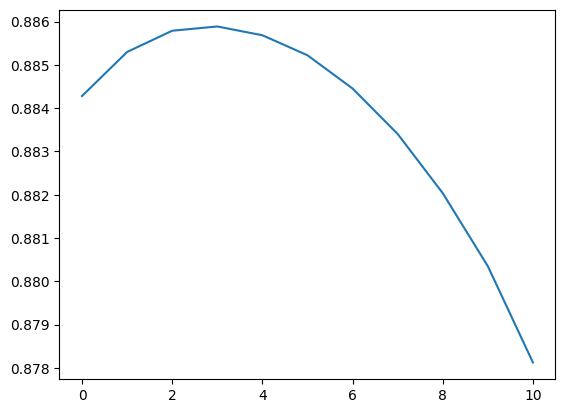

In [22]:
rf_weight = 0.5
import matplotlib.pyplot as plt

aucs = np.zeros(8)
for fold in range(5):
    print(f'Fold: {fold}')

    Xv, yv = valids[fold]
    Xv_xgb = Xv[X_use_cols]

    # Calculate ROCS

    # np.array(xgboosts[fold].predict_proba(Xv_xgb))
    xgb_preds = np.array(xgboosts[fold].predict_proba(Xv))
    rf_preds = np.array(rfs[fold].predict_proba(Xv))[:,:,1].T
    preds = rf_weight * rf_preds + (1 - rf_weight) * xgb_preds

    aucs += np.array(roc_auc_score(yv, preds, multi_class='ovr', average=None))

val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
essential_aucs = val_aucs.drop(index='No Defect')
print(f'Mean AUC of 7: {essential_aucs.mean():.4f}')

mean_aucs = []

for i in range(11):
    print(f'{i+1}/11')
    rf_weight = i/10
    aucs = np.zeros(8)
    for fold in range(5):
        Xv, yv = valids[fold]
        #Xv_xgb = Xv[X_use_cols]

        # Calculate ROCS
        # np.array(xgboosts[fold].predict_proba(Xv_xgb))
        xgb_preds = np.array(xgboosts[fold].predict_proba(Xv))
        rf_preds = np.array(rfs[fold].predict_proba(Xv))[:, :, 1].T
        preds = rf_weight * rf_preds + (1 - rf_weight) * xgb_preds

        aucs += np.array(roc_auc_score(yv, preds, multi_class='ovr', average=None))
    val_aucs = pd.Series(aucs, index=y_cols)/5
    essential_aucs = val_aucs.drop(index='No Defect')
    print(f'Mean AUC for weights rf{i/10:.1f}-xgb{1-i/10:.1f}: {essential_aucs.mean():.4f}')
    mean_aucs.append(essential_aucs.mean())

plt.plot(mean_aucs)
plt.show()